In [1]:
import os
import scipy.io
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pickle
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt


# Converting boxcars into indexes

In [2]:
def load_cache(path, encoding="latin-1", fix_imports=True):
        """
        encoding latin-1 is default for Python2 compatibility
        """
        with open(path, "rb") as f:
            return pickle.load(f, encoding=encoding, fix_imports=True)
        
def create_unique_ann_list():
        
        for data in dataset['samples']:
            new_ann = data['annotation']
            if new_ann not in cars_annotations:
                cars_annotations.append(new_ann)

def convert_ann_to_num(ann):
    if ann not in cars_annotations:
        cars_annotations.append(ann)
    return cars_annotations.index(ann)

In [3]:
cars_annotations = []
split = load_cache('../data/BoxCars/classification_splits.pkl')['hard']
dataset = load_cache('../data/BoxCars/dataset.pkl')
atlas = load_cache('../data/BoxCars/atlas.pkl')

create_unique_ann_list()
print('Number of annotations ' + str(len(cars_annotations)))

Number of annotations 693


In [4]:
load_cache('../data/BoxCars/classification_splits.pkl')['hard'].keys()

dict_keys(['test', 'types_mapping', 'train', 'test_cameras', 'validation'])

In [5]:
load_cache('../data/BoxCars/classification_splits.pkl')['hard']['types_mapping']

{'hyundai ix20 mpv mk1': 87,
 'ford focus combi mk3': 0,
 'audi a6 combi mk4': 88,
 'ford focus combi mk1': 1,
 'skoda roomster van mk1': 29,
 'ford focus combi mk2': 2,
 'skoda fabia hatchback mk3': 95,
 'skoda fabia hatchback mk2': 30,
 'skoda fabia hatchback mk1': 31,
 'hyundai i20 hatchback mk1': 28,
 'skoda superb sedan mk2': 60,
 'citroen berlingo van mk2': 33,
 'citroen c3 hatchback mk1': 89,
 'peugeot 207 hatchback mk1': 62,
 'opel vivaro van mk2': 90,
 'peugeot 107 hatchback mk1': 34,
 'skoda superb combi mk2': 3,
 'skoda yeti suv mk1': 4,
 'fiat ducato van mk3': 18,
 'ford mondeo combi mk4': 35,
 'ford mondeo combi mk3': 36,
 'hyundai i30 hatchback mk1': 63,
 'hyundai i30 hatchback mk2': 64,
 'volvo xc90 suv mk1': 65,
 'volkswagen golf hatchback mk4': 66,
 'volkswagen golf hatchback mk6': 67,
 'toyota yaris hatchback mk3': 37,
 'volkswagen passat sedan mk6': 46,
 'bmw x3 suv mk2': 38,
 'volkswagen tiguan suv mk1': 39,
 'toyota auris combi mk2': 91,
 'porsche cayenne suv mk2':

In [6]:
def get_unique_list(li):
    return list(set(li))

def create_unique_multitask_list():    
    make = []
    mode = []
    submodel = []
    generation = []
    
    for new_ann in cars_annotations:
        t_make,t_model,t_submodel,t_generation = new_ann.split()
        make.append(t_make)
        mode.append(t_model)
        submodel.append(t_submodel)
        generation.append(t_generation)
    return get_unique_list(make),get_unique_list(mode),get_unique_list(submodel),get_unique_list(generation)
make,model,submodel,generation = create_unique_multitask_list()

In [7]:
print("make:",len(make))
print("model:",len(model))
print("submodel:",len(submodel))
print("generation:",len(generation))

make: 45
model: 338
submodel: 11
generation: 11


In [8]:
def separate_classes():
    arr = []
    for idx, annotation in enumerate(cars_annotations):
        make,model,submodel,generation = annotation.split()
        arr.append((idx, annotation,make, model, submodel, generation))
    arr = pd.DataFrame(arr, columns=['target', 'full_annotation','make', 'model', 'submodel', 'generation'])
    return arr
v2_info = separate_classes()

In [9]:
make_codes = v2_info['make'].astype('category').cat.codes
make_codes

0      35
1      35
2      35
3      35
4      35
       ..
688    14
689    31
690    41
691     7
692    28
Length: 693, dtype: int8

The hard split contains 107 fine-grained classes 
11 653 tracks (51 691 images) for training and 11 125 tracks (39 149 images)
for testing

In [10]:
import scipy.io
def load_anno(path):
    mat = scipy.io.loadmat(path)
    return mat

def load_class_names(path="/Users/martinodonnell/Documents/uni/fourth_year/4006/LowResImageRecognision/data/StanfordCars/devkit/cars_meta.mat"):
    cn = load_anno(path)['class_names']
    cn = cn.tolist()[0]
    cn = [str(c[0].item()) for c in cn]
    return cn

test = load_class_names()

In [11]:
test

['AM General Hummer SUV 2000',
 'Acura RL Sedan 2012',
 'Acura TL Sedan 2012',
 'Acura TL Type-S 2008',
 'Acura TSX Sedan 2012',
 'Acura Integra Type R 2001',
 'Acura ZDX Hatchback 2012',
 'Aston Martin V8 Vantage Convertible 2012',
 'Aston Martin V8 Vantage Coupe 2012',
 'Aston Martin Virage Convertible 2012',
 'Aston Martin Virage Coupe 2012',
 'Audi RS 4 Convertible 2008',
 'Audi A5 Coupe 2012',
 'Audi TTS Coupe 2012',
 'Audi R8 Coupe 2012',
 'Audi V8 Sedan 1994',
 'Audi 100 Sedan 1994',
 'Audi 100 Wagon 1994',
 'Audi TT Hatchback 2011',
 'Audi S6 Sedan 2011',
 'Audi S5 Convertible 2012',
 'Audi S5 Coupe 2012',
 'Audi S4 Sedan 2012',
 'Audi S4 Sedan 2007',
 'Audi TT RS Coupe 2012',
 'BMW ActiveHybrid 5 Sedan 2012',
 'BMW 1 Series Convertible 2012',
 'BMW 1 Series Coupe 2012',
 'BMW 3 Series Sedan 2012',
 'BMW 3 Series Wagon 2012',
 'BMW 6 Series Convertible 2007',
 'BMW X5 SUV 2007',
 'BMW X6 SUV 2012',
 'BMW M3 Coupe 2012',
 'BMW M5 Sedan 2010',
 'BMW M6 Convertible 2010',
 'BMW X3

In [12]:
def load_annotations_v2(path, v2_info):
    ann = load_anno(path)['annotations'][0]
    ret = {}
    make_codes = v2_info['make'].astype('category').cat.codes
    type_codes = v2_info['model_type'].astype('category').cat.codes

    for idx in range(len(ann)):
        x1, y1, x2, y2, target, imgfn = ann[idx]

        r = {
            'x1': x1.item(),
            'y1': y1.item(),
            'x2': x2.item(),
            'y2': y2.item(),
            'target': target.item() - 1,
            'make_target': make_codes[target.item() - 1].item(),
            'type_target': type_codes[target.item() - 1].item(),
            'filename': imgfn.item()
        }

        ret[idx] = r
    return ret

# Adding Augmentations to images

In [13]:
# -*- coding: utf-8 -*-
import cv2
import numpy as np
import random


#%%
def alter_HSV(img, change_probability = 0.6):
    if random.random() < 1-change_probability:
        return img
    addToHue = random.randint(0,179)
    addToSaturation = random.gauss(60, 20)
    addToValue = random.randint(-50,50)
    hsvVersion =  cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    channels = hsvVersion.transpose(2, 0, 1)
    channels[0] = ((channels[0].astype(int) + addToHue)%180).astype(np.uint8)
    channels[1] = (np.maximum(0, np.minimum(255, (channels[1].astype(int) + addToSaturation)))).astype(np.uint8)
    channels[2] = (np.maximum(0, np.minimum(255, (channels[2].astype(int) + addToValue)))).astype(np.uint8)
    hsvVersion = channels.transpose(1,2,0)   
        
    return cv2.cvtColor(hsvVersion, cv2.COLOR_HSV2RGB)

#%%
def image_drop(img, change_probability = 0.6):
    if random.random() < 1-change_probability:
        return img
    width = random.randint(int(img.shape[1]*0.10), int(img.shape[1]*0.3))
    height = random.randint(int(img.shape[0]*0.10), int(img.shape[0]*0.3))
    x = random.randint(int(img.shape[1]*0.10), img.shape[1]-width-int(img.shape[1]*0.10))
    y = random.randint(int(img.shape[0]*0.10), img.shape[0]-height-int(img.shape[0]*0.10))
    img[y:y+height,x:x+width,:] = (np.random.rand(height,width,3)*255).astype(np.uint8)
    return img

#%%
def add_bb_noise_flip(image, bb3d, flip, bb_noise):
    bb3d = bb3d + bb_noise 
    if flip:
        bb3d[:, 0] = image.shape[1] - bb3d[:,0]
        image = cv2.flip(image, 1)
    return image, bb3d

#%%
def _unpack_side(img, origPoints, targetSize):
    origPoints = np.array(origPoints).reshape(-1,1,2)
    targetPoints = np.array([(0,0), (targetSize[0],0), (0, targetSize[1]), 
                             (targetSize[0], targetSize[1])]).reshape(-1,1,2).astype(origPoints.dtype)
    m, _ = cv2.findHomography(origPoints, targetPoints, 0)
    resultImage = cv2.warpPerspective(img, m, targetSize)
    return resultImage
    
    
#%%    
def unpack_3DBB(img, bb):
    frontal = _unpack_side(img, [bb[0], bb[1], bb[4], bb[5]], (75,124))
    side = _unpack_side(img, [bb[1], bb[2], bb[5], bb[6]], (149,124))
    roof = _unpack_side(img, [bb[0], bb[3], bb[1], bb[2]], (149,100))
    final = np.zeros((224,224,3), dtype=frontal.dtype)
    final[100:, 0:75] = frontal
    final[0:100, 75:] = roof
    final[100:, 75:] = side
    
    return final

In [14]:
def get_vehicle_instance_data(vehicle_id, instance_id, original_image_coordinates=False):
    """
    original_image_coordinates: the 3DBB coordinates are in the original image space
                                to convert them into cropped image space, it is necessary to subtract instance["3DBB_offset"]
                                which is done if this parameter is False. 
    """
    vehicle = dataset["samples"][vehicle_id]
    instance = vehicle["instances"][instance_id]
    bb3d = instance["3DBB"]

    return vehicle, instance, bb3d


In [15]:
def get_image(vehicle_id, instance_id):
    return cv2.cvtColor(cv2.imdecode(atlas[vehicle_id][instance_id], 1), cv2.COLOR_BGR2RGB)

In [16]:
path = '/Users/martinodonnell/Documents/uni/fourth_year/4006/LowResImageRecognision/data/BoxCars/images/'

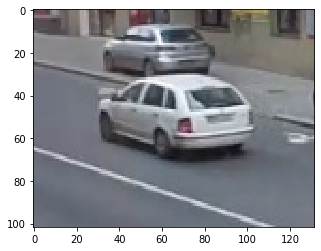

In [155]:
vehicle_id, instance_id,bb3d = get_vehicle_instance_data(0,0)
image = get_image(0,0)
# image = Image.open(path + instance_id['path'])
#Convert from pil to cv
# image = np.array(image)

# image = alter_HSV(image,1) # randomly alternate color
# image = image_drop(image,1) # randomly remove part of the image
# bb_noise = np.clip(np.random.randn(2) * 1.5, -5, 5) # generate random bounding box movement
# flip = bool(random.getrandbits(1)) # random flip
# image, bb3d = add_bb_noise_flip(image, bb3d, flip, bb_noise) 

# image = unpack_3DBB(image, bb3d) 
# image = (image.astype(np.float32) - 116)/128.

# plt.plot(image)
# plt.show()
# len(image)
plt.imshow(image)
plt.show()

# Checking single sample from each boxcar class

In [18]:
filepaths = ['uvoz/0/000000_000.png',
'uvoz/1/000001_000.png',
'uvoz/2/000002_000.png',
'uvoz/5/000005_000.png',
'uvoz/6/000006_000.png',
'uvoz/7/000007_000.png',
'uvoz/8/000008_000.png',
'uvoz/12/000012_000.png',
'uvoz/15/000015_000.png',
'uvoz/26/000026_000.png',
'uvoz/30/000030_000.png',
'uvoz/33/000033_000.png',
'uvoz/37/000037_000.png',
'uvoz/43/000043_000.png',
'uvoz/47/000047_000.png',
'uvoz/49/000049_000.png',
'uvoz/43/000093_000.png',
'videnska/13/000213_000.png',
'videnska/25/000225_000.png',
'videnska/24/000324_000.png',
'videnska/1/000351_000.png',
'prahaVinohradska/30/000430_000.png',
'prahaVinohradska/31/000431_000.png',
'prahaVinohradska/32/000432_000.png',
'prahaVinohradska/33/000433_000.png',
'prahaVinohradska/36/000436_000.png',
'prahaVinohradska/44/000444_000.png',
'prahaVinohradska/49/000449_000.png',
'prahaVinohradska/7/000457_000.png',
'prahaVinohradska/8/000458_000.png',
'prahaVinohradska/15/000465_000.png',
'prahaVinohradska/16/000466_000.png',
'prahaVinohradska/19/000469_000.png',
'prahaVinohradska/26/000476_000.png',
'prahaVinohradska/33/000483_000.png',
'prahaVinohradska/46/000496_000.png',
'prahaVinohradska/47/000497_000.png',
'prahaVinohradska/13/000513_000.png',
'prahaVinohradska/16/000516_000.png',
'prahaVinohradska/19/000519_000.png',
'prahaVinohradska/43/000543_000.png',
'prahaVinohradska/6/000556_000.png',
'prahaVinohradska/9/000559_000.png',
'prahaVinohradska/33/000583_000.png',
'prahaVinohradska/47/000597_000.png',
'prahaVinohradska/3/000603_000.png',
'prahaVinohradska/5/000605_000.png',
'prahaVinohradska/24/000624_000.png',
'prahaVinohradska/7/000707_000.png',
'prahaVinohradska/45/000795_000.png',
'prahaVinohradska/43/000843_000.png',
'prahaVinohradska/23/000873_000.png',
'prahaVinohradska/27/000977_000.png',
'prahaVinohradska/33/001033_000.png',
'prahaVinohradska/21/001121_000.png',
'prahaVinohradska/19/001219_000.png',
'prahaVinohradska/16/001616_000.png',
'prahaVinohradska/12/001812_000.png',
'prahaVinohradska/43/002093_000.png',
'prahaVinohradska/28/002178_000.png',
'prahaVinohradska/48/002548_000.png',
'prahaVinohradska/22/002822_000.png',
'prahaVinohradska/8/002958_000.png',
'prahaVinohradska/10/003110_000.png',
'videnska/31/004281_000.png',
'videnska/15/004315_000.png',
'fit/3/005053_000.png',
'fit/6/005056_000.png',
'fit/15/005065_000.png',
'fit/16/005066_000.png',
'fit/36/005086_000.png',
'fit/37/005087_000.png',
'fit/5/005105_000.png',
'fit/25/005125_000.png',
'fit/47/005147_000.png',
'fit/20/005270_000.png',
'fit/4/005354_000.png',
'fit/1/005451_000.png',
'fit/40/005540_000.png',
'fit/3/005553_000.png',
'fit/27/005677_000.png',
'fit/37/007337_000.png',
'fit/41/009141_000.png',
'fit/18/009768_000.png',
'001/28/019678_000.png',
'001/38/019688_000.png',
'001/42/019692_000.png',
'001/13/019713_000.png',
'001/17/019717_000.png',
'001/2/019752_000.png',
'001/3/019753_000.png',
'001/25/019775_000.png',
'001/28/019778_000.png',
'001/30/019780_000.png',
'001/11/019811_000.png',
'001/49/019849_000.png',
'001/14/019864_000.png',
'002/41/019991_000.png',
'002/5/020005_000.png',
'002/17/020167_000.png',
'002/46/020196_000.png',
'002/33/020283_000.png',
'003/49/020449_000.png',
'003/38/020638_000.png',
'007/25/021375_000.png',
'009/25/021775_000.png',
'013/33/022233_000.png']

In [19]:
filepaths[18]

'videnska/25/000225_000.png'

In [20]:
count = 54

In [21]:
print(count)

54


In [22]:
filepaths[count]

'prahaVinohradska/21/001121_000.png'

In [23]:
# count+=1
Image.open(path +"001/17/019717_000")


FileNotFoundError: [Errno 2] No such file or directory: '/Users/martinodonnell/Documents/uni/fourth_year/4006/LowResImageRecognision/data/BoxCars/images/001/17/019717_000'

In [ ]:
# How many samples for each car

In [ ]:
boxcar_counts = {'skoda fabia combi mk1': 4056, 'skoda fabia hatchback mk2': 1383, 'skoda octavia combi mk2': 4298, 'skoda fabia combi mk2': 3087, 'skoda octavia sedan mk3': 1159, 'skoda octavia combi mk3': 794, 'skoda octavia combi mk1': 2751, 'volkswagen passat combi mk6': 341, 'skoda fabia hatchback mk1': 2947, 'skoda superb sedan mk2': 198, 'skoda rapid sedan mk1': 273, 'skoda octavia sedan mk1': 2738, 'skoda octavia sedan mk2': 2185, 'skoda superb combi mk2': 239, 'volkswagen passat combi mk7': 88, 'volkswagen golf hatchback mk6': 178, 'volkswagen passat sedan mk6': 227, 'volkswagen passat sedan mk5': 89, 'skoda superb sedan mk1': 187, 'volkswagen passat combi mk5': 668, 'skoda fabia sedan mk1': 189, 'skoda yeti suv mk1': 592, 'volkswagen caddy van mk3': 538, 'skoda citigo hatchback mk1': 1157, 'ford focus combi mk1': 807, 'peugeot 206 hatchback mk1': 569, 'skoda felicia combi mk2': 265, 'skoda felicia hatchback mk1': 925, 'fiat panda hatchback mk2': 336, 'citroen berlingo van mk2': 495, 'bmw x5 suv mk2': 121, 'audi a6 combi mk4': 101, 'hyundai i20 hatchback mk1': 290, 'bmw x3 suv mk2': 133, 'porsche cayenne suv mk2': 60, 'citroen berlingo van mk1': 597, 'ford fiesta hatchback mk6': 145, 'skoda felicia hatchback mk2': 958, 'peugeot partner van mk2': 218, 'skoda favorit hatchback mk1': 195, 'audi a6 sedan mk4': 294, 'toyota auris combi mk2': 121, 'toyota yaris hatchback mk3': 228, 'hyundai ix20 mpv mk1': 420, 'renault megane combi mk3': 381, 'opel corsa hatchback mk4': 164, 'ford mondeo combi mk3': 242, 'seat alhambra mpv mk1': 69, 'skoda felicia combi mk1': 117, 'bmw 1 hatchback mk1': 75, 'ford focus combi mk3': 140, 'volkswagen golf combi mk4': 105, 'volkswagen touareg suv mk2': 171, 'volkswagen sharan mpv mk1': 401, 'kia ceed combi mk1': 417, 'fiat punto hatchback mk1': 190, 'audi q7 suv mk1': 135, 'renault kangoo van mk1': 141, 'volkswagen golf hatchback mk4': 523, 'volkswagen tiguan suv mk1': 86, 'hyundai i30 hatchback mk1': 133, 'ford focus combi mk2': 312, 'opel corsa hatchback mk3': 175, 'hyundai i30 combi mk2': 381, 'skoda roomster van mk1': 1206, 'peugeot 107 hatchback mk1': 223, 'opel astra combi mk2': 171, 'renault megane combi mk2': 251, 'citroen c1 hatchback mk1': 293, 'hyundai i30 hatchback mk2': 211, 'renault clio hatchback mk2': 315, 'renault trafic van mk2': 388, 'ford s-max mpv mk1': 223, 'seat cordoba sedan mk2': 112, 'seat leon hatchback mk2': 109, 'ford fusion mpv mk1': 550, 'renault laguna combi mk2': 94, 'volkswagen touran mpv mk1': 254, 'ford focus hatchback mk1': 329, 'fiat punto hatchback mk2': 141, 'peugeot 207 hatchback mk1': 76, 'renault megane hatchback mk3': 124, 'ford focus hatchback mk2': 194, 'renault thalia sedan mk1': 145, 'hyundai getz hatchback mk1': 125, 'renault scenic mpv mk1': 121, 'volvo xc90 suv mk1': 122, 'opel vivaro van mk2': 134, 'ford transit van mk6': 438, 'peugeot partner van mk1': 175, 'volkswagen transporter van mk5': 417, 'kia sportage suv mk3': 143, 'renault master van mk2': 153, 'citroen c3 hatchback mk1': 187, 'volvo xc60 suv mk1': 114, 'volkswagen transporter van mk4': 383, 'ford mondeo combi mk4': 157, 'peugeot 308 combi mk1': 81, 'renault kangoo van mk2': 145, 'peugeot boxer van mk3': 117, 'peugeot 307 combi mk1': 161, 'ford transit van mk7': 265, 'fiat ducato van mk3': 192, 'hyundai ix35 suv mk1': 178, 'fiat doblo van mk1': 163, 'skoda fabia hatchback mk3': 139, 'renault master van mk3': 174}


In [ ]:
{k: v for k, v in sorted(boxcar_counts.items(), key=lambda item: item[1])}